In [42]:
import numpy as np
import scipy.io.wavfile as wav
import pandas as pd
import matplotlib.pyplot as plt
import soundfile as sf
from python_speech_features import mfcc
import os, time, glob, json, torch, csv, librosa
import librosa.display
#from wave import open

In [43]:
#各檔案路徑
audio_path = 'dataset/data_sr/data'
label_path = 'dataset/data_sr/data'

audio_csv_path = 'dataset/data_sr/audio_sample.csv'
label_csv_path = 'dataset/data_sr/label_sample.csv'

In [9]:
# 取得 label 檔名與內容
def get_labels_and_texts(label_path):
    labels = []
    labels_path = []
    label_texts = []
    for(dirpath, dirnames, filenames) in os.walk(label_path):
        for filename in filenames:
            if filename.endswith('.json'):
                #取得 label 的完整路徑，後面進行讀檔
                filename_path = os.path.join(dirpath, filename)
                labels_path.append(filename_path)
                
                #取得 label的檔名，後面對應到音檔
                try:
                    index = filename.index("_")
                except ValueError:
                    index = filename.index(".")
                    
                filename = filename[:index]
                labels.append(filename)
    for label_file in labels_path:
        #讀取 label 檔，並將 command 以 one-hot encoding 方式改寫 label
        try:
            with open(label_file) as fd:
                data = json.load(fd)
                a = 0
                b = 0
                c = 0
                d = 0
                if data['command'] == 'open':
                    a = 1
                elif data['command'] == 'close':
                    b = 1
                elif data['command'] == 'hold':
                    c = 1
                else:
                    d = 1
                data = [a,b,c,d]
                label_texts.append(data)
                fd.close()
        except ValueError:
            continue
    return labels, label_texts

labels, label_texts = get_labels_and_texts(label_path)

print(labels[0], label_texts[0])

1633056677 [0, 0, 0, 1]


In [10]:
#將 檔名與 label 寫入 csv 檔
'''
i = 0
for label_text in label_texts:
    label_text.insert(0, labels[i])
    i+=1

with open(label_csv_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['檔名','請開', '請關', '請保持', '其他'])
    
    for label_text in label_texts:
        writer.writerow(label_text)
print(label_texts[0])
'''

['1633056677', 0, 0, 0, 1]


In [44]:
# 取得 wav 音檔路徑
def get_wavs(wav_path):
    wavs = []
    for (dirpath, dirnames, filenames) in os.walk(wav_path):
        for filename in filenames:
            if filename.endswith('.wav') or filename.endswith('.WAV'):
                filename_path = os.path.join(dirpath, filename)
                wavs.append(filename_path)
    return wavs

wavs = get_wavs(audio_path)

In [40]:
# 將 flac 音檔轉成 wav 音檔
def get_flacs(audio_path):
    flacs = []
    flac_filename = []
    for (dirpath, dirnames, filenames) in os.walk(audio_path):
        for filename in filenames:
            if filename.endswith('.flac'):
                filename_path = os.path.join(dirpath, filename)
                
                index = filename.index(".")
                    
                filename = filename[:index]
                flac_filename.append(filename)
                
                flacs.append(filename_path)
    return flacs, flac_filename

flacs,flac_filename = get_flacs(audio_path)

i = 0
for flac in flacs:
    try:
        audio, sr = sf.read(flac)
    except RuntimeError:
        print(flac)
    sf.write(audio_path+'/'+flac_filename[i]+'.wav', audio, sr, 'PCM_16')
    i+=1

dataset/data_sr/data/1623372994.flac
dataset/data_sr/data/1623373198.flac
dataset/data_sr/data/1624246529.flac
dataset/data_sr/data/1619576718.flac
dataset/data_sr/data/1623373076.flac
dataset/data_sr/data/1623373306.flac
dataset/data_sr/data/1620697758.flac
dataset/data_sr/data/1624246517.flac
dataset/data_sr/data/1620697415.flac
dataset/data_sr/data/1620697761.flac
dataset/data_sr/data/1620698062.flac
dataset/data_sr/data/1623373169.flac
dataset/data_sr/data/1620698334.flac
dataset/data_sr/data/1623373060.flac
dataset/data_sr/data/1620697764.flac
dataset/data_sr/data/1623372974.flac
dataset/data_sr/data/1620697767.flac
dataset/data_sr/data/1620697512.flac


In [45]:
# mfcc function
# 将音频数据转为时间序列（列）和MFCC（行）的矩阵，将对应的译文转成字向量
def get_mfccs(wavs, n_input, contexts):
    file = []
    audio = []
    audio_len = []
    
    for wav_file in wavs:
        # load audio and convert to features
        audio_data = audiofile_to_input_vector(wav_file, n_input, contexts)
        try:
            audio_data = audio_data.astype('float32')
            
            file.append(wav_file)
            audio.append(audio_data)
            audio_len.append(np.int32(len(audio_data)))
        except AttributeError:
            print()
 
    audio = np.asarray(audio,dtype=object)
    audio_len = np.asarray(audio_len)
    
    return file, audio, audio_len
 
# 将音频信息转成MFCC特征
# 参数说明---audio_filename：音频文件   numcep：梅尔倒谱系数个数
#       numcontext：对于每个时间段，要包含的上下文样本个数
def audiofile_to_input_vector(audio_filename, numcep, numcontext):
    # 加载音频文件
    try:
        fs, audio = wav.read(audio_filename)
        orig_inputs = mfcc(audio, samplerate=fs, numcep=numcep)
        # 打印MFCC系数的形状，得到比如(955, 26)的形状
        # 955表示时间序列，26表示每个序列的MFCC的特征值为26个
        # 这个形状因文件而异，不同文件可能有不同长度的时间序列，但是，每个序列的特征值数量都是一样的
        #print('orig_inputs shape', np.shape(orig_inputs))

        # 因为我们使用双向循环神经网络来训练,它的输出包含正、反向的结
        # 果,相当于每一个时间序列都扩大了一倍,所以
        # 为了保证总时序不变,使用orig_inputs =
        # orig_inputs[::2]对orig_inputs每隔一行进行一次
        # 取样。这样被忽略的那个序列可以用后文中反向
        # RNN生成的输出来代替,维持了总的序列长度。
        orig_inputs = orig_inputs[::2]  # (478, 26)
        # print(np.shape(orig_inputs))
        # 因为我们讲解和实际使用的numcontext=9，所以下面的备注我都以numcontext=9来讲解
        # 这里装的就是我们要返回的数据，因为同时要考虑前9个和后9个时间序列，
        # 所以每个时间序列组合了19*26=494个MFCC特征数
        train_inputs = np.array([], np.float32)
        train_inputs.resize((orig_inputs.shape[0], numcep + 2 * numcep * numcontext))
        #print('train_inputs shape', np.shape(train_inputs))#)(478, 494)

        # Prepare pre-fix post fix context
        empty_mfcc = np.array([])
        empty_mfcc.resize((numcep))

        # Prepare train_inputs with past and future contexts
        # time_slices保存的是时间切片，也就是有多少个时间序列
        time_slices = range(train_inputs.shape[0])

        # context_past_min和context_future_max用来计算哪些序列需要补零
        context_past_min = time_slices[0] + numcontext
        context_future_max = time_slices[-1] - numcontext

        # 开始遍历所有序列
        for time_slice in time_slices:
            # 对前9个时间序列的MFCC特征补0，不需要补零的，则直接获取前9个时间序列的特征
            need_empty_past = max(0, (context_past_min - time_slice))
            empty_source_past = list(empty_mfcc for empty_slots in range(need_empty_past))
            data_source_past = orig_inputs[max(0, time_slice - numcontext):time_slice]
            assert (len(empty_source_past) + len(data_source_past) == numcontext)

            # 对后9个时间序列的MFCC特征补0，不需要补零的，则直接获取后9个时间序列的特征
            need_empty_future = max(0, (time_slice - context_future_max))
            empty_source_future = list(empty_mfcc for empty_slots in range(need_empty_future))
            data_source_future = orig_inputs[time_slice + 1:time_slice + numcontext + 1]
            assert (len(empty_source_future) + len(data_source_future) == numcontext)

            # 前9个时间序列的特征
            if need_empty_past:
                past = np.concatenate((empty_source_past, data_source_past))
            else:
                past = data_source_past
            # 后9个时间序列的特征
            if need_empty_future:
                future = np.concatenate((data_source_future, empty_source_future))
            else:
                future = data_source_future

            # 将前9个时间序列和当前时间序列以及后9个时间序列组合
            past = np.reshape(past, numcontext * numcep)
            now = orig_inputs[time_slice]
            future = np.reshape(future, numcontext * numcep)

            train_inputs[time_slice] = np.concatenate((past, now, future))
            assert (len(train_inputs[time_slice]) == numcep + 2 * numcep * numcontext)

        # 将数据使用正太分布标准化，减去均值然后再除以方差
        train_inputs = (train_inputs - np.mean(train_inputs)) / np.std(train_inputs)

        return train_inputs
    except ValueError:
        print(audio_filename)
    
 
#对齐处理
def pad_sequences(sequences, maxlen=None, dtype=np.float32,
                  padding='post', truncating='post', value=0.):
    #[478 512 503 406 481 509 422 465]
    lengths = np.asarray([len(s) for s in sequences], dtype=np.int64)
 
    nb_samples = len(sequences)
 
    #maxlen，该批次中，最长的序列长度
    if maxlen is None:
        maxlen = np.max(lengths)
 
    # 在下面的主循环中，从第一个非空序列中获取样本形状以检查一致性
    sample_shape = tuple()
    for s in sequences:
        if len(s) > 0:
            sample_shape = np.asarray(s).shape[1:]
            break
 
    x = (np.ones((nb_samples, maxlen) + sample_shape) * value).astype(dtype)
    for idx, s in enumerate(sequences):
        if len(s) == 0:
            continue  # 序列为空，跳过
 
        #post表示后补零，pre表示前补零
        if truncating == 'pre':
            trunc = s[-maxlen:]
        elif truncating == 'post':
            trunc = s[:maxlen]
        else:
            raise ValueError('Truncating type "%s" not understood' % truncating)
 
        # check `trunc` has expected shape
        trunc = np.asarray(trunc, dtype=dtype)
        if trunc.shape[1:] != sample_shape:
            raise ValueError('Shape of sample %s of sequence at position %s is different from expected shape %s' %
                             (trunc.shape[1:], idx, sample_shape))
 
        if padding == 'post':
            x[idx, :len(trunc)] = trunc
        elif padding == 'pre':
            x[idx, -len(trunc):] = trunc
        else:
            raise ValueError('Padding type "%s" not understood' % padding)
 
    return x, lengths


# 梅尔倒谱系数的个数
n_input = 26
# 对于每个时间序列，要包含上下文样本的个数
contexts = 9

file, audio, audio_len = get_mfccs(wavs, n_input, contexts)
audio, audio_len = pad_sequences(audio)

dataset/data_sr/data/1618243237.wav

dataset/data_sr/data/1618243179.wav

dataset/data_sr/data/1618243233.wav



In [46]:
# 將 檔名與特徵寫入 csv 檔

aa = []
for(dirpath, dirnames, filenames) in os.walk(audio_path):
    for filename in filenames:
            if filename.endswith('.wav') or filename.endswith('.WAV'):                
                #取得 wav的檔名
                index = filename.index('.')
                filename = filename[:index]
                aa.append(filename)

a_list = list(audio)
i = 0
b = {}
c = []
for a in a_list:
    b = {"檔名":aa[i],"特徵": a}
    c.append(b)
    i+=1
col = ["檔名", "特徵"]
try:
    with open(audio_csv_path, 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=col)
        writer.writeheader()
        #writer.writerow(['檔名','特徵'])

        for data in c:
            writer.writerow(data)
except IOError:
    print("I/O error")


In [11]:
#load label csv into pd to preview data
labels = pd.read_csv(label_csv_path)
labels

,檔名,請開,請關,請保持,其他
0,1633056677,0,0,0,1
1,1648290403,0,0,0,1
2,1651108191,0,0,0,1
3,1632317974,0,0,0,1
4,1637285404,0,0,0,1
...,...,...,...,...,...
91143,1632585432,0,0,0,1
91144,1631260537,0,0,0,1
91145,1633837183,0,0,0,1
91146,1631060620,0,0,0,1


In [47]:
#load audio csv into pd to preview data
audios = pd.read_csv(audio_csv_path)
audios

,檔名,特徵
0,1631855145,[[ 0.12715088 0.12715088 0.12715088 ... 0.1...
1,1619349620,[[ 0.06157185 0.06157185 0.06157185 ... 0.0...
2,1618415564,[[ 0.01064791 0.01064791 0.01064791 ... 0.0...
3,1627011377,[[ 0.15257801 0.15257801 0.15257801 ... 0.1...
4,1633141439,[[ 0.04986587 0.04986587 0.04986587 ... 0.0...
...,...,...
85479,1632813265,[[0.11326524 0.11326524 0.11326524 ... 0.11937...
85480,1619505028,[[ 0.04749758 0.04749758 0.04749758 ... 0.0...
85481,1642131941,[[ 0.1067288 0.1067288 0.1067288 ... 0.1...
85482,1642252224,[[ 4.2699456e-02 4.2699456e-02 4.2699456e-02...


In [ ]:
# combine all csvs into one
def return_contents(file_name):
    with open(file_name) as infile:
        reader = csv.reader(infile)
        return list(reader)

all_files = os.listdir('dataset/data_sr/audio_sample')
combined_output = []

for file in all_files:
    data = return_contents('dataset/data_sr/audio_sample/{}'.format(file))
    for row in data:
        combined_output.extend(row)

with open('dataset/data_sr/audio_sample.csv', 'w', newline='') as outfile:
    writer = csv.writer(outfile)
    writer.writerow(combined_output)

In [ ]:
# read all audio sample csv
audio_csvs_path = 'dataset/data_sr/audio_sample'
csv = glob.glob(audio_csvs_path + "/*.csv")

li = []
for filename in csv:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)
    
df = pd.concat(li, axis=0, ignore_index=True)
df.head()

In [ ]:
# using python_speech_features to extract mfcc feartures
from python_speech_features import mfcc
from python_speech_features import logfbank
import scipy.io.wavfile as wav
import numpy
import os

# directory where we your .wav files are
directoryName = "dataset/data_sr/train" # put your own directory here
# directory to put our results in, you can change the name if you like
resultsDirectory = 'dataset/data_sr/audio_sample'

# make a new folder in this directory to save our results in
if not os.path.exists(resultsDirectory):
    os.makedirs(resultsDirectory)

# get MFCCs for every .wav file in our specified directory 
for filename in os.listdir(directoryName):
    if filename.endswith('.wav'): # only get MFCCs from .wavs
        # read in our file
        '''
        try:
            (rate,sig) = wav.read(directoryName + "/" +filename)
        except ValueError:
            continue
        # get mfcc
        mfcc_feat = mfcc(sig,rate)

        # get filterbank energies
        fbank_feat = logfbank(sig,rate)
        '''
        # create a file to save our results in
       
        outputFile = resultsDirectory + "/" + os.path.splitext(filename)[0] + ".csv"
        file = open(outputFile, 'w+') # make file/over write existing file
        numpy.savetxt(file, fbank_feat, delimiter=",") #save MFCCs as .csv
        file.close() # close file

(20, 73)
(20, 73)


/tmp/ipykernel_25494/3710940075.py:15: FutureWarning: Pass y=[ 0.00934298  0.00031414 -0.01070536 ... -0.03821031 -0.04278069
 -0.02737672] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(x, sr=fs)


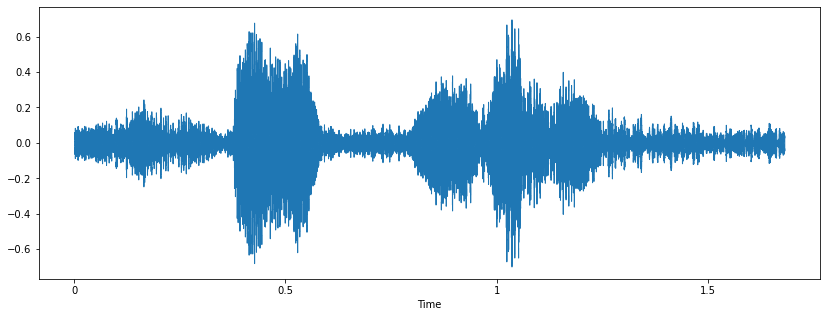

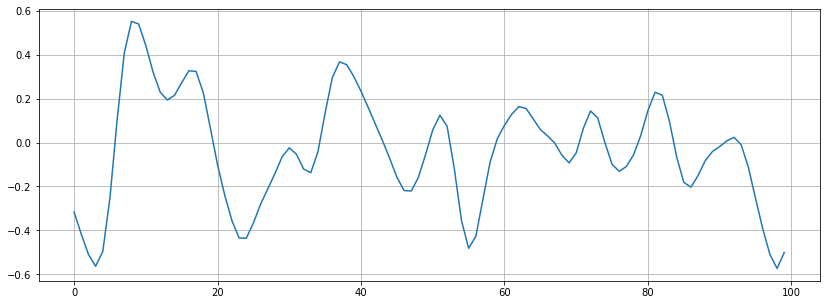

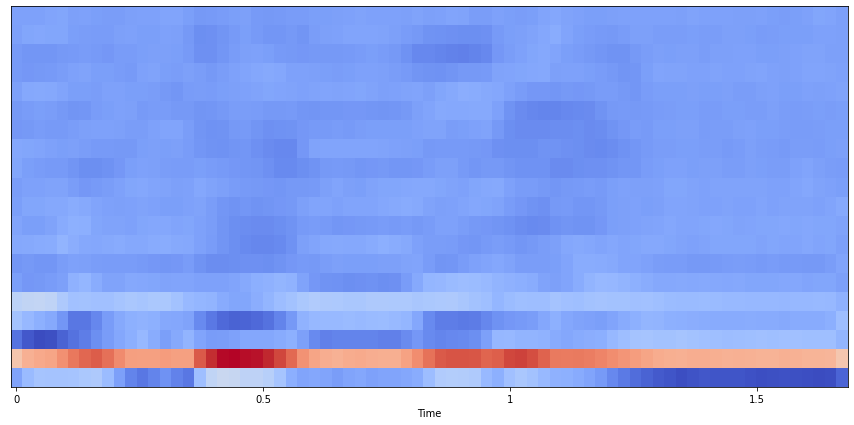

In [44]:
# using librosa to extract mfcc features
x, sr = librosa.load(wavs[0])

#Plot the signal:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(x, sr=sr)
# Zooming in
n0 = 9000
n1 = 9100
plt.figure(figsize=(14, 5))
plt.plot(x[n0:n1])
plt.grid()

fs=10
mfccs = librosa.feature.mfcc(x, sr=fs)

print(mfccs.shape)
#Displaying  the MFCCs:
plt.figure(figsize=(15, 7))
librosa.display.specshow(mfccs, sr=sr, x_axis='time')